<a href="https://colab.research.google.com/github/EunKyung-o/NIPA_AI/blob/master/01_%ED%95%84%EC%88%98_%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5%EC%9C%BC%EB%A1%9C%20%EC%A3%BC%EA%B0%80%20%EC%98%88%EC%B8%A1%20%EC%B2%B4%ED%97%98%ED%95%98%EA%B8%B0/03%20%EC%A3%BC%EA%B0%80%20%EC%98%88%EC%B8%A1%EC%9D%84%20%EC%9C%84%ED%95%9C%20%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5%20%EB%AA%A8%EB%8D%B8%20%EB%A7%8C%EB%93%A4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from datetime import datetime # 날짜와 시간을 쉽게 조작할 수 있게 하는 클래스 제공
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Activation

# 딥러닝의 입력피쳐 설계

In [1]:
# 주식 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/NIPA_실전 데이터 분석 및 인공지능 활용/01 인공지능으로 주가 예측 체험하기/data/stock.csv') 
print('주식 데이터 확인하기')
print(df)


# 주가의 중간값 계산하기
high_prices = df['High'].values # 고가
low_prices = df['Low'].values # 저가
mid_prices = (high_prices + low_prices) / 2 # 고가와 저가의 중간값
print('주가의 중간값:', mid_prices)


# 주가 데이터에 중간 값 요소 추가하기
df['Mid'] = mid_prices # 'Mid' 열을 새로 만들고 mid_prices 데이터를 넣습니다.
print(df)


# 종가의 이동평균값을 계산하고 및 주가 데이터에 추가합니다.
ma5 = df['Adj Close'].rolling(window=5).mean()
df['MA5'] = ma5 # 'MA5' 열을 새로 만들고 ma5 값을 넣습니다.


df = df.fillna(0) # 비어있는 값을 모두 0으로 바꾸기
print(df)

주식 데이터 확인하기
           Date   High    Low   Open  Close    Volume  Adj Close
0    2020-03-02  55500  53600  54300  55000  30403412      55000
1    2020-03-03  56900  55100  56700  55400  30330295      55400
2    2020-03-04  57600  54600  54800  57400  24765728      57400
3    2020-03-05  58000  56700  57600  57800  21698990      57800
4    2020-03-06  57200  56200  56500  56500  18716656      56500
..          ...    ...    ...    ...    ...       ...        ...
100  2020-07-24  54400  53700  54000  54200  10994535      54200
101  2020-07-27  55700  54300  54300  55600  21054421      55600
102  2020-07-28  58800  56400  57000  58600  48431566      58600
103  2020-07-29  60400  58600  60300  59000  36476611      59000
104  2020-07-30  60100  59000  59700  59000  19285354      59000

[105 rows x 7 columns]
주가의 중간값: [54550. 56000. 56100. 57350. 56700. 56500. 54300. 53200. 52100. 49225.
 49850. 48175. 46975. 44475. 44525. 42975. 45000. 48375. 48500. 48275.
 47450. 47825. 46850. 46100. 4707

# 데이터 전처리

In [3]:
# Date 열을 제거합니다.
df = df.drop('Date', axis = 1)


# 데이터 스케일링(MinMaxScaler 적용)
min_max_scaler = MinMaxScaler()
fitted = min_max_scaler.fit(df)
output = min_max_scaler.transform(df)
output = pd.DataFrame(output, columns=df.columns, index=list(df.index.values))


print('\n전처리 후의 주가 데이터')
print(output.head())


전처리 후의 주가 데이터
       High       Low      Open  ...  Adj Close       Mid       MA5
0  0.709199  0.676647  0.661017  ...   0.757576  0.698341  0.000000
1  0.792285  0.766467  0.796610  ...   0.781818  0.785822  0.000000
2  0.833828  0.736527  0.689266  ...   0.903030  0.791855  0.000000
3  0.857567  0.862275  0.847458  ...   0.927273  0.867270  0.000000
4  0.810089  0.832335  0.785311  ...   0.848485  0.828054  0.984986

[5 rows x 8 columns]


# 데이터셋 나누기

In [4]:
# 0~60% 지점까지를 트레인셋(학습 데이터)으로 설정(전체의 60%)
train_size = int(len(output)* 0.6) 

# 60-90% 지점까지를 테스트셋으로 설정(전체의 30%)
test_size = int(len(output)*0.3) + train_size


#train/test 학습 및 라벨 설정
#종가를 예측하기 위해 종가를 label로 설정
train_x = np.array(output[:train_size]) # 트레인셋의 독립변수
train_y = np.array(output['Close'][:train_size]) # 트레인셋의 종속변수
test_x =np.array(output[train_size:test_size]) # 테스트셋의 독립변수
test_y = np.array(output['Close'][train_size:test_size]) # 테스트셋의 종속변수
validation_x = np.array(output[test_size:]) # 트레인셋의 독립변수
validation_y = np.array(output['Close'][test_size:]) # 테스트셋의 종속변수

print('분할 전 전체 데이터의 길이: %s' % len(output))
print('학습 데이터의 길이: %s' % len(train_x))
print('테스트 데이터의 길이: %s' % len(test_x))
print('검증용 데이터의 길이: %s' % len(validation_x))

분할 전 전체 데이터의 길이: 105
학습 데이터의 길이: 63
테스트 데이터의 길이: 31
검증용 데이터의 길이: 11


# Keras를 이용한 딥러닝 수행

In [5]:
model = Sequential() # Keras 모델을 생성합니다.

# Keras 딥러닝 모델 학습을 위한 파라미터(옵션값)을 설정합니다.
# 현재 단계에서 각 파라미터에 대한 세부적인 내용까지 알 필요는 없으므로, 너무 걱정하지 마세요.
learning_rate = 0.01
training_cnt = 1000
batch_size = 100 
input_size = 8 

# 생성된 딥러닝 모델에 학습용 데이터(train_x)를 넣습니다.
# 마찬가지로 구체적인 코드를 처음부터 모두 이해하고 외울 필요는 없습니다.
model.add(Dense(input_size, activation='tanh', input_shape=(train_x.shape[1],))) 
model.add(Dense(input_size * 3,  activation='tanh')) 
model.add(Dense(1, activation='tanh'))

# 데이터를 학습을 진행합니다.
model.compile(optimizer='sgd', loss='mse', metrics=['mae', 'mape','acc'])
model.summary()
history = model.fit(train_x, train_y, epochs=training_cnt,   
                    batch_size=batch_size, verbose=1)
val_mse, val_mae, val_mape, val_acc = model.evaluate(test_x, test_y, verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 24)                216       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 313
Trainable params: 313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1665 - mae: 0.3785 - mape: 572417.9375 - acc: 0.0159
Epoch 2/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.1183 - mae: 0.3102 - mape: 247912.4688 - acc: 0.0159
Epoch 3/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0866 - mae: 0.2578 - mape: 902847.1875 - acc: 0.0159
Epoch 4

# 인공지능으로 주가 예측해보기

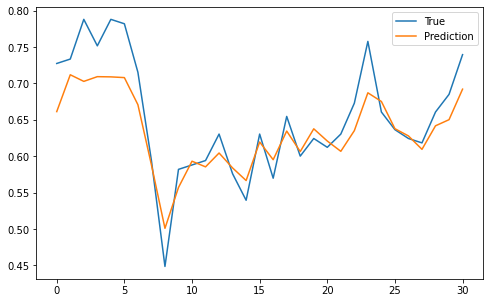

In [7]:
# 학습된 모델로부터 테스트 데이터를 예측합니다.
pred = model.predict(test_x)

fig = plt.figure(facecolor='white', figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(test_y, label='True') # 실제 주가
ax.plot(pred, label='Prediction') # 우리가 만든 딥러닝 모델이 예측한 주가
ax.legend()

# 현재까지 그려진 그래프를 시각화
plt.savefig("plot.png")